In [31]:
import torch
import torch.nn as nn
import numpy as np
import time
from function import fun1,fun2,fun3,fun4,fun5,fun6
from my_NN import *
import os
import matplotlib.pyplot as plt
import ycx_para_config as ycx


using_func=ycx.choose_fun

def fun1_real(fn, x, dx):
    return fn**2/(1-dx*fn)
def fun2_real(fn, x, dx):
    return 2*x+dx
def fun3_real(fn, x, dx):
    return fn*(torch.exp(dx)-1)/dx

now_real_fun=ycx.choose_real_fun

if_know_kernel=ycx.if_know_real_kernel

now_lx_model=False

# 确保 model 文件夹存在
os.makedirs('./model_parameter_consist', exist_ok=True)

In [32]:
if torch.cuda.is_available():
    device='cuda'
    print('now using cuda !')
else:
    device='cpu'
    print('now using cpu !')
dtype=torch.float32
    
model=ycx.NN().to(device=device,dtype=dtype)
#load model parameter
new_file_name=ycx.consist_para_file_name

if now_lx_model:new_file_name='test_7_8_3_standard.pth'

model.load_state_dict(torch.load(new_file_name))

now using cuda !


/tmp/ipykernel_2406421/4151024575.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(new_file_name))


<All keys matched successfully>

In [33]:
def sample_t_per_interval_and_generate_f_start(dtype,device,seg_step=16,batch_size=32,f_start_min=0.1,f_start_max=0.9):
    t_seg=torch.linspace(0,1,seg_step+1,dtype=dtype,device=device)
    t_seg=t_seg.repeat(batch_size,1)
    
    rand_move=torch.empty((batch_size,seg_step+1),dtype=dtype,device=device).uniform_(-ycx.random_amplititude/seg_step,ycx.random_amplititude/seg_step)
    rand_move[:,0]=0
    rand_move[:,-1]=0
    
    t_seg+=rand_move
    f_start_rand=torch.empty((batch_size,1),dtype=dtype,device=device).uniform_(f_start_min,f_start_max)
    
    return t_seg , f_start_rand

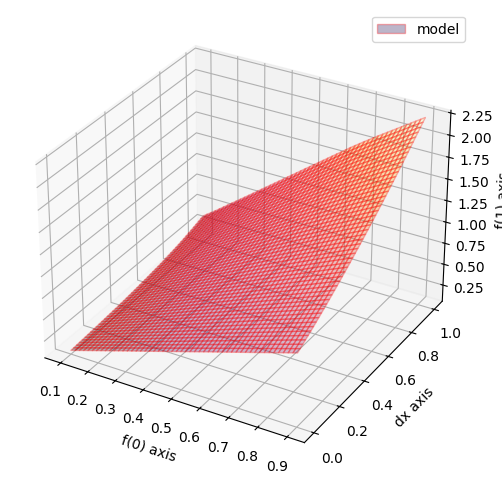

In [34]:
#这里的图示，只能在明确知道kernel的情况下，才能画出真实与预测对比的图像，否则只能画出预测的图示
fns = torch.linspace(ycx.f_start_min, ycx.f_start_max, 1000).to(device,dtype=dtype)
dx = torch.linspace(0, 1, 1000).to(device,dtype=dtype)
fns, dx = torch.meshgrid(fns, dx)

x = torch.zeros((1000, 1000, 1), device=device,dtype=dtype)

if if_know_kernel:real_value = fns.unsqueeze(-1)+dx.unsqueeze(-1)*now_real_fun(fns.unsqueeze(-1), x, dx.unsqueeze(-1))
model_value = fns.unsqueeze(-1)+dx.unsqueeze(-1)*model(fns.unsqueeze(-1), x, dx.unsqueeze(-1))

if if_know_kernel:real_value = real_value.squeeze(-1)
model_value = model_value.squeeze(-1)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
# 要将张量传递给不支持 GPU 操作的库（如 Matplotlib）时，需要使用 .cpu() 方法将其转换为 CPU 张量。
if if_know_kernel:ax.plot_surface(fns.cpu().numpy(), dx.cpu().numpy(), real_value.cpu().numpy(), cmap='viridis', alpha=0.7,color='b',label='real')

# 绘制预测模型的表面
ax.plot_surface(fns.cpu().numpy(), dx.cpu().numpy(), model_value.detach().cpu().numpy(), cmap='inferno', alpha=0.3,color='r',label='model')

ax.set_xlabel('f(0) axis')
ax.set_ylabel('dx axis')
ax.set_zlabel('f(1) axis')
plt.legend()
plt.show()

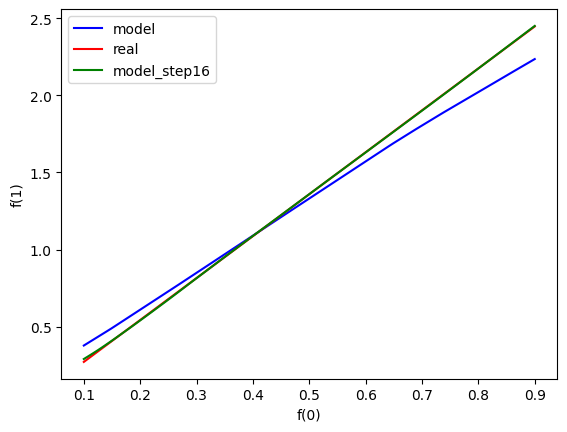

In [35]:
#这里用于展示不同f(0)下的f(1)的值，在真实情况、一步预测情况、多步（step_len)预测情况下的对比
length=100
dx=torch.zeros(length).unsqueeze(-1).to(device=device,dtype=dtype)+1
x=torch.zeros(length).unsqueeze(-1).to(device=device,dtype=dtype)
f0=torch.linspace(ycx.f_start_min,ycx.f_start_max,length).unsqueeze(-1).to(device=device,dtype=dtype)

model_value_sf=f0.squeeze(-1)+(dx.squeeze(-1))*model(f0,x,dx).squeeze(-1)
real_value_sf=using_func(f0).squeeze(-1)

value=[]
model_step_value=f0.clone()
model_step_value=model_step_value.repeat(ycx.aver_num,1,1)
#model_step_value用来表示经过多步到达的f(1)nn值

''''''
step_len=ycx.choose_seg_step

x_step=torch.linspace(0,1,step_len+1).unsqueeze(-1).to(device=device,dtype=dtype)

for l in range(ycx.aver_num):
    rand_move=torch.empty(step_len+1,dtype=dtype,device=device).uniform_(-ycx.random_amplititude/step_len,ycx.random_amplititude/step_len)
    rand_move[0]=0
    rand_move[-1]=0
    temp_step=x_step+rand_move.unsqueeze(-1)

    temp_step=temp_step.repeat(1,length).unsqueeze(-1)
    dx_step=temp_step[1:]-temp_step[:-1]

    for i in range(step_len):
        model_step_value[l]=model_step_value[l]+model(model_step_value[l],temp_step[i],dx_step[i])*dx_step[i]
        
model_step_value=model_step_value.squeeze(-1)
model_step_value=torch.mean(model_step_value,dim=0)

plt.plot(f0.detach().cpu(),model_value_sf.detach().cpu(),c='b',label='model')
plt.plot(f0.detach().cpu(),real_value_sf.detach().cpu(),c='r',label='real')
plt.plot(f0.detach().cpu(),model_step_value.detach().cpu(),c='g',label=f'model_step{step_len}')
plt.xlabel('f(0)')
plt.ylabel('f(1)')
plt.legend()


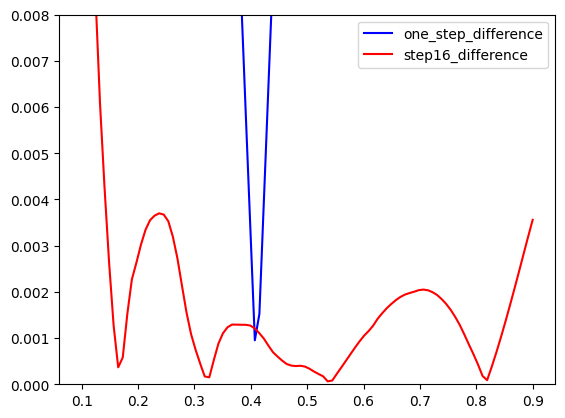

In [36]:
if ycx.relative_error:
    difference=torch.abs((model_value_sf-real_value_sf)/real_value_sf)
    step_difference=torch.abs((model_step_value-real_value_sf)/real_value_sf)
else:
    difference=torch.abs((model_value_sf-real_value_sf))
    step_difference=torch.abs((model_step_value-real_value_sf))

plt.plot(f0.detach().cpu(),difference.detach().cpu(),c='b',label='one_step_difference')
plt.plot(f0.detach().cpu(),step_difference.detach().cpu(),c='r',label=f'step{step_len}_difference')
plt.ylim(ycx.ylim)
plt.legend()

0.075119205 0.0019488638


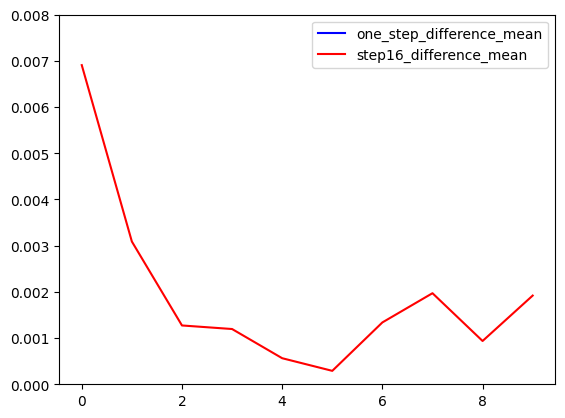

In [37]:
dif=difference.detach().cpu().numpy()
dif_step=step_difference.detach().cpu().numpy()
print(np.mean(dif),np.mean(dif_step))

dif_mean=np.zeros(10)
for i in range(10):
    dif_mean[i]=np.mean(dif[i*10:(i+1)*10])
    
dif_step_mean=np.zeros(10)
for i in range(10):
    dif_step_mean[i]=np.mean(dif_step[i*10:(i+1)*10])
    
plt.plot(dif_mean,c='b',label='one_step_difference_mean')
plt.plot(dif_step_mean,c='r',label=f'step{step_len}_difference_mean')
plt.ylim(ycx.ylim)
plt.legend()
plt.show()
